# Clustering Document Elements

How do we cluster the elements inside a document? This exploration attempts to solve this.

In [5]:
# Important block for all of our needs
import os
os.sys.path.append(os.path.dirname(os.path.abspath('.')))

import sys
import inspect
# reload(sys)  
# sys.setdefaultencoding('utf8')
base_path = os.path.realpath(
    os.path.abspath(
        os.path.join(
            os.path.split(
                inspect.getfile(
                    inspect.currentframe()
                )
            )[0],
            '..',
            'Arthur.workspace'
        )
    )
)

arthur_libs_path = os.path.join(
    base_path, 
    'libs',
    'arthur'
)

sys.path.append(base_path)
sys.path.append(arthur_libs_path)

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html).decode('utf-8')
    
def fprint(*args, **kwargs):
    """Print numpy array in full (i.e. instead of hiding some elements with "...")
    """
    from pprint import pprint
    import numpy
    opt = numpy.get_printoptions()
    numpy.set_printoptions(threshold='nan')
    pprint(*args, **kwargs)
    numpy.set_printoptions(**opt)

## 1. Quick Split

In this section we will try splitting the elements by the simplest methods possible.

### 1.1. Plot all document elements

First let's just plot all document elements to know what we are dealing with.

In [6]:
# This is how we convert our list of dicts into list of values that can
# be imported into numpy. The difference is in the project we use namedtuple, which means
# replacing d['features'] with d.features.
import numpy as np

data = [{'text': 'one', 'features': {'x': 1, 'y': 1}}, {'text': 'two', 'features': {'x': 2, 'y': 2}}]
print [[d['features'][k] for k in sorted(d['features'])] for d in data]

[[1, 1], [2, 2]]


In [7]:
d = np.array([[0, 1, 2], [1, 2, 3]])
d2 = np.where(d[0] == 1)
print d[np.where((d[:,1] == 2) * (d[:,2] == 3))]

[[1 2 3]]


Get all features:

In [10]:
from libs.arthur.document import ArthurDocument

pdf_path = 'pdfs/05337591.pdf'
f = open(pdf_path, 'rb')
document = ArthurDocument(f.read(), doctype='pdf')
features = document.get_features()
features

array([[ -1.00000000e+00,  -1.00000000e+00,   1.00000000e+00, ...,
          5.99999760e+01,   1.30203116e+01,   2.39283072e+01],
       [ -1.00000000e+00,  -1.00000000e+00,   1.00000000e+00, ...,
          6.58799736e+01,   1.30203116e+01,   2.39283072e+01],
       [ -1.00000000e+00,  -1.00000000e+00,   1.00000000e+00, ...,
          7.18799712e+01,   1.30203116e+01,   2.39283072e+01],
       ..., 
       [  1.00000000e+00,   2.36000000e+02,   3.00000000e+00, ...,
          1.03920000e+02,   2.06304000e+03,   2.06316000e+03],
       [  5.70000000e+01,   4.80000000e+01,   3.00000000e+00, ...,
          8.08800000e+01,   2.07456000e+03,   2.08140000e+03],
       [  6.00000000e+01,   4.80000000e+01,   3.00000000e+00, ...,
          8.08800000e+01,   2.15844000e+03,   2.16564000e+03]])

Get feature names:

In [11]:
ArthurDocument.get_feature_names()

['img_height',
 'img_width',
 'page',
 'size',
 'textbox_id',
 'textline_id',
 'x',
 'x1',
 'y',
 'y1']

Below plot shows position of characters on all pages. The catch here is that y = 2500 to 2000 maps page 3, y 1500-ish to 800-ish page 2, and 800-ish to 0 page 1.

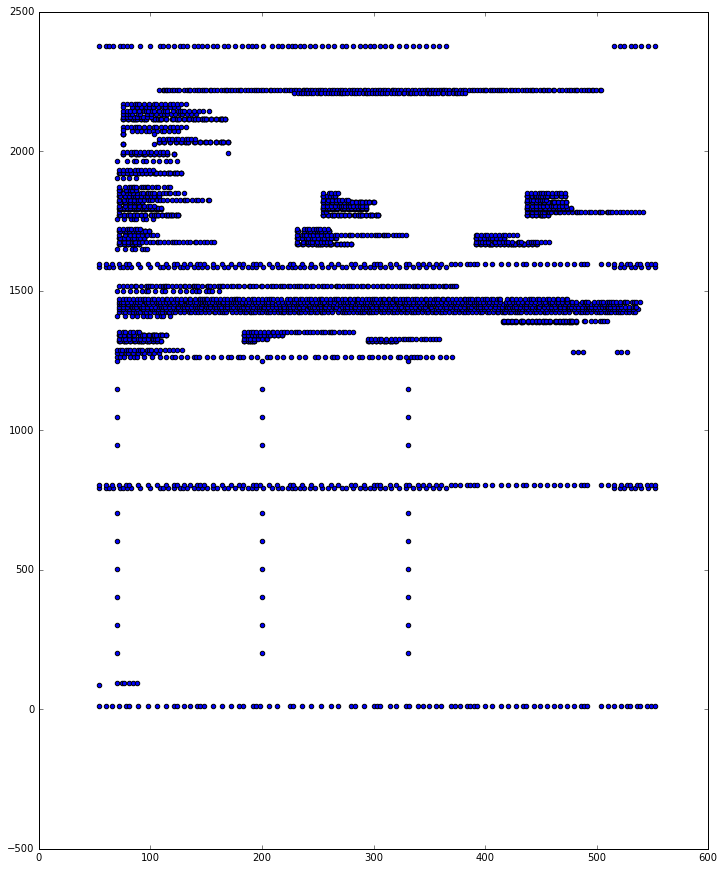

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
x = features[:,ArthurDocument.get_feature_names().index('x')]
y = features[:,ArthurDocument.get_feature_names().index('y')]
plt.figure(figsize=(12,15))
plt.scatter(x,y)
plt.show()

For next step, we will try out a couple of machine learning algorithms to see if we can split them correctly.

### 1.2. Split by textbox id
Let's try to split the docs by textbox id and see if that could be a system with high enough precision.

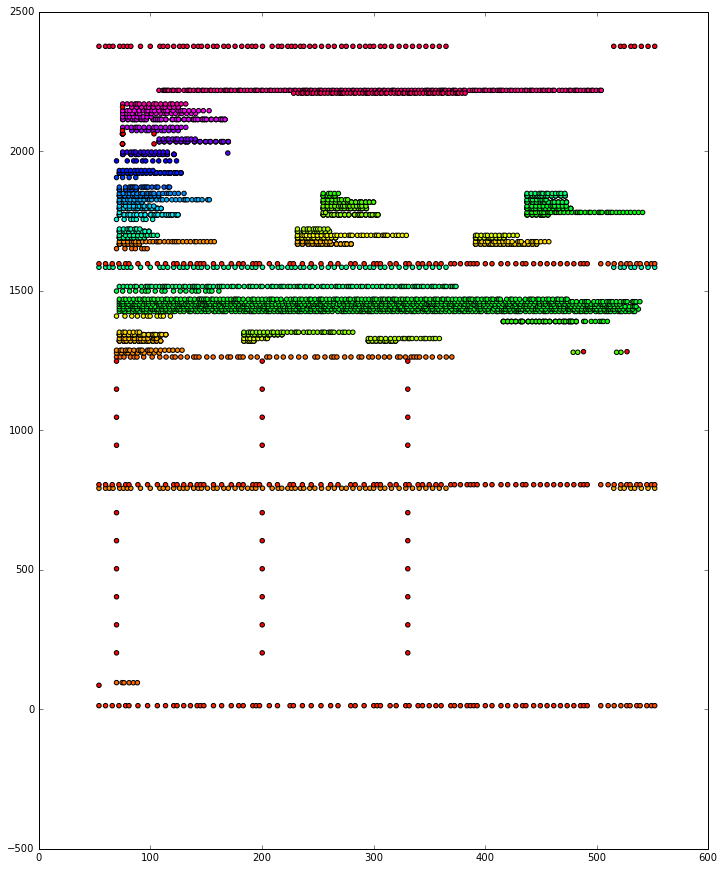

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

x = features[:,ArthurDocument.get_feature_names().index('x')]
y = features[:,ArthurDocument.get_feature_names().index('y')]
c = features[:,ArthurDocument.get_feature_names().index('textbox_id')]
plt.figure(figsize=(12,15))
plt.scatter(x,y, c=c, cmap='hsv')
plt.show()

### 1.3. Split by k-means algorithm

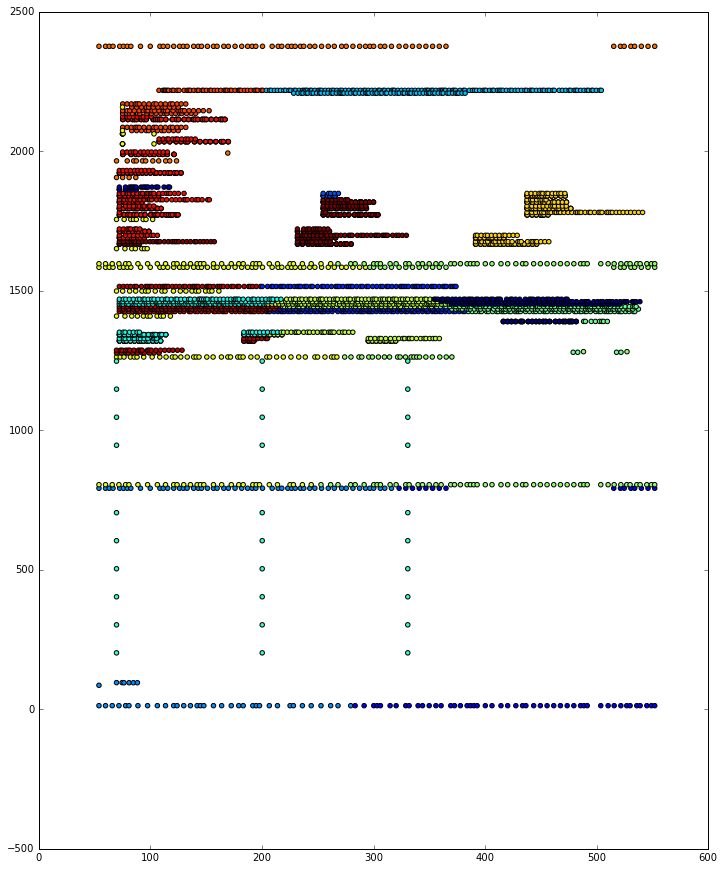

In [14]:
# First attempt: Use sklearn with KMeans algorithm (old-school, weak classifier).

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

random = 13

feature_names = ArthurDocument.get_feature_names()

feature_union = FeatureUnion([
    ('scale', MinMaxScaler())
])

estimators = [
    ('features', feature_union),
    ('classify', KMeans(random_state=random, n_clusters=20))
]

classifier = Pipeline(estimators)

classifier.fit(features)

predicted = classifier.predict(features)

x = features[:,ArthurDocument.get_feature_names().index('x')]
y = features[:,ArthurDocument.get_feature_names().index('y')]

plt.figure(figsize=(12,15))
plt.scatter(x,y, c=predicted)
plt.show()

It doesn't work as well as textbox splitting it seems. Looks like separation needs to be done without machine learning at least for now.

## 2. Deeper exploration to splitting by textboxes

Let's reconstruct all texts based on their `textbox_id` and see what we get:

In [15]:
from libs.arthur.document import ArthurDocument
import numpy as np

pdf_path = 'pdfs/05337591.pdf'
f = open(pdf_path, 'rb')
document = ArthurDocument(f.read(), doctype='pdf')
features = document.get_features()

In [16]:
table = ListTable()
table.append(['page', 'textbox_id', 'x (of textbox)', 'y (of textbox)', 'content'])
i = 1
page_features = features[np.where(features[:,ArthurDocument.get_feature_id('page')] == i)]
while len(page_features) > 0:
    j = 0
    textbox_features = page_features[np.where(page_features[:,ArthurDocument.get_feature_id('textbox_id')] == j)]
    while len(textbox_features) > 0:
        x = textbox_features[0, ArthurDocument.get_feature_id('x')]
        y = textbox_features[0, ArthurDocument.get_feature_id('y')]
        table.append([i, j, x, y, document.get_text(textbox_features)])
        j += 1
        textbox_features = page_features[np.where(page_features[:,ArthurDocument.get_feature_id('textbox_id')] == j)]
    i += 1
    page_features = features[np.where(features[:,ArthurDocument.get_feature_id('page')] == i)]

table

page,textbox_id,x (of textbox),y (of textbox),content
1,0,53.9999784,13.020311592,"1191 ROUTE 785, UTOPIA, NEW BRUNSWICK, New Brunswick E5C2L3 -0533759..."
1,1,503.639798544,13.020311592,Page 1 of 3
1,2,69.719972112,95.6114785555,< Back
1,3,53.9999784,792.29999988,http://www.realtor.ca/propertyDetails.aspx?PropertyId=15119807
1,4,515.279793888,792.29999988,6/1/2015
2,0,53.9999784,805.020311592,"1191 ROUTE 785, UTOPIA, NEW BRUNSWICK, New Brunswick E5C2L3 -0533759..."
2,1,503.639798544,805.020311592,Page 2 of 3
2,2,69.719972112,1262.67828853,"1191 ROUTE 785, UTOPIA, NEW BRUNSWICK, New Brunswick E5C2L3"
2,3,69.719972112,1277.27292269,"$9,650,000 Listing ID: 05337591"
2,4,72.479971008,1320.04186558,Property TypeProperty Type Property TypeProperty Type Single Family


Alright, at this point we know the following:

- We can split the documents based on the characters and textboxes contained in them.
- We can get position of each character and textboxes, and basically any element in a document.
- Text can be reconstructed based on x and y position of each feature as shown in above table.

### 2.1. Problems with the above technique

1. "Property TypeProperty TypeProperty TypeProperty Type Single Family" should be "Property Type Single Family".
2. "http://www.realtor.ca/propertyDetails.aspx?PropertyId=15119807" should stay as it is.

The most reliable way to handle this is by checking element positions and add spaces as needed. Simple words detection won't suffice due to existence of case #2 (i.e. it has "PropertyId").

### 2.2. Textbox correction by removing duplicates and adding spaces

Let's implement a fix for the problems above.

#### 2.2.1. Finding distances between all coordinates.

K-d Tree algorithm. Code from [this discussion](http://stackoverflow.com/questions/10818546/finding-index-of-nearest-point-in-numpy-arrays-of-x-and-y-coordinates). We will make the points dataset much smaller so we can assert if the algorithm was correct.

In [17]:
import numpy as np
from scipy.spatial import cKDTree

# Original code - used to benchmark algorithm speed. But we need a proof of concept
# so we build something much simpler.
#
# y_array = np.random.random(10000).reshape(100,100)
# x_array = np.random.random(10000).reshape(100,100)

# points = np.random.random(10000).reshape(2,5000)

# combined_x_y_arrays = np.dstack([y_array.ravel(),x_array.ravel()])[0]
# points_list = list(points.transpose())


# First coordinate should be close to point 3, second one to point 2, and third one to point 1.

combined_x_y_arrays = np.array([[0,0], [100,100], [200,200]])
points_list = np.array([[210,208], [150,130], [30,40]])

def do_kdtree(combined_x_y_arrays,points):
    mytree = cKDTree(combined_x_y_arrays)
    dist, indexes = mytree.query(points)
    return indexes

results2 = do_kdtree(combined_x_y_arrays,points_list)
print(results2)

[2 1 0]


#### 2.2.2. Finding distances with certain thresholds

We will eventually want to remove points that are very close together. For that we need to use certain thresholds in K-d tree.

In [18]:
import numpy as np
from scipy.spatial import cKDTree

# This should return only the first point.

combined_x_y_arrays = np.array([[0,0], [100,100], [200,200]])
points_list = np.array([[210,208], [150,130], [30,40]])

def do_kdtree_within(combined_x_y_arrays,points, distance_upper_bound):
    mytree = cKDTree(combined_x_y_arrays)
    dist, indexes = mytree.query(points,distance_upper_bound=distance_upper_bound)
    return indexes

# Finds points with distance no further than 20.
results2 = do_kdtree_within(combined_x_y_arrays,points_list,20)
print(results2)

[2 3 3]


Alright, turns out the behavior is to **assign non-existent indexes to points outside the upper bound.**

#### 2.2.3. Querying against itself

In Arthur, we will query the coordinates against themselves. Using `query` method as described above, each point would just return itself. Let's explore the possibility of other bulk methods to help us to work around this.

In [19]:
import numpy as np
from scipy.spatial import cKDTree

# Some points are positioned nearby in this example.

coordinates = np.array([[0,0], [1,1], [2,2], [100,100], [101,102], [200,200]])

def do_kdtree_self(coordinates, radius):
    mytree = cKDTree(coordinates)
    neighbors = mytree.query_ball_point(coordinates,radius)
    return neighbors

# Finds points with distance no further than 20.
neighbors = do_kdtree_self(coordinates,20)
print(neighbors)

[[0, 1, 2] [0, 1, 2] [0, 1, 2] [3, 4] [3, 4] [5]]


Awesome! From the result we see that nearby elements are grouped together. The next step would then just to remove duplicates.

In [20]:
np.unique(neighbors)

array([[0, 1, 2], [3, 4], [5]], dtype=object)

### 2.3. Correcting blocks in Arthur

Armed with this new knowledge, we can now bring this into Arthur's blocks correction algorithm.

But first, let's analyze positions of elements inside a block.

In [21]:
# This code piece groups all textboxes into a list

from libs.arthur import ArthurDocument as ad
page_feature_id = ad.get_feature_id('page')
textbox_feature_id = ad.get_feature_id('textbox_id')
xfid = ad.get_feature_id('x')
yfid = ad.get_feature_id('y')
page_textbox_pairs = features[:, [page_feature_id, textbox_feature_id]]
unique_page_textbox_pairs = unique_rows(page_textbox_pairs)

texts = []
blocks = []

for page, textbox_id in unique_page_textbox_pairs(features, page_feature_id, textbox_feature_id):
    bfeats = features[np.where(
        (features[:, page_feature_id]==page) * 
        (features[:, textbox_feature_id]==textbox_id)
    )]
    
    # bfeats contains all features inside a textbox.
    texts.append(document.get_text(bfeats))
    blocks.append(bfeats)

print("text:")
print(texts[11])

table = ListTable()
table.append(['id', 'x', 'y', 'char', 'id', 'x', 'y', 'char', 'id', 'x', 'y', 'char'])
import math
nrows = int(math.ceil(len(blocks[11])/3))
print nrows
cp = [] # close points
for idx in range(0, nrows):
    fs = [blocks[11][idx],
          blocks[11][idx+nrows],
          blocks[11][idx+nrows*2]]
    ts = []
    counter = idx
    for f in fs:
        t1 = f[xfid]
        t2 = f[yfid]
        t3 = document.get_text(f)
        if t3 == 'P':
            t1 = '<b>%f</b>' % t1
            t2 = '<b>%f</b>' % t2
            t3 = '<b>%s</b>' % t3
            cp.append(f)
        ts.append(counter)
        ts.append(t1)
        ts.append(t2)
        ts.append(t3)
        counter += nrows
    table.append(ts)
table

NameError: name 'unique_rows' is not defined

Distance between closely positioned elements:

In [ ]:
((cp[1][xfid] - cp[0][xfid])**2 + (cp[1][yfid] - cp[0][yfid])**2)**(1/2.0)

And now to actually correct the blocks.

In [ ]:
from scipy.spatial import cKDTree

def correct_block(block, return_details=False):
    """Corrects block elements.
    
    Args:
        block(np.array): Block to correct
        
        return_details(bool): If True, return list instead of only corrected block. This list
                              contains details needed for debugging:
                              - removed features
                              - added features
                              Defaults to False
    """
    fxid = ArthurDocument.get_feature_id('x')
    fyid = ArthurDocument.get_feature_id('y')
    positions = block[:,[fxid,fyid]]
    tree = cKDTree(positions)

    # Removes duplicate elements that are close together
    radius = 0.4
    neighbors = tree.query_ball_point(positions, radius)
    neighbors = np.unique(neighbors)
    # This returns numpy array like:
    # [[0, 13, 26, 39] [1, 14, 27, 40] [5, 31, 44, 18] [11, 24, 37, 50]
    # [16, 29, 42, 3] [17, 30, 43, 4] [21, 8, 34, 47] [22, 35, 48, 9]
    # [32, 45, 19, 6] [36, 23, 10, 49] [38, 12, 25, 51] [41, 28, 2, 15]
    # [46, 33, 7, 20] [52] [53] [54] [55] [56] [57] [58] [59] [60] [61] [62]
    # [63] [64]]
    #
    # Which we will then remove duplicates e.g. remove index 13, 26, 39, 14, 27, etc.
    removed = []
    for n in neighbors:
        removed.extend(np.sort(n)[1:])
    cblock = np.delete(block, removed, axis=0)
    
    if return_details:
        return (cblock, removed)
    else:
        return cblock

# Let's try correcting Property Type block and see what we get.
cblock, removed = correct_block(blocks[11], return_details=True)
print("feature ids removed: ")
print(removed)
print "\nresult:"
print(document.get_text(cblock))